# Análisis Final de Resultados ML: Longs + Shorts

Este notebook consolida los resultados de las estrategias de Machine Learning (Random Forest y CatBoost) para operaciones Long y Short, comparando su desempeño global contra la estrategia Baseline en el periodo de Test (Out-of-Sample).

In [38]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100


## 1. Definición de Funciones de Métricas

In [26]:
def calculate_strategy_metrics(df, name="Strategy"):
    """
    Calcula métricas clave de trading para un DataFrame de trades.
    """
    if df is None or len(df) == 0:
        print(f"--- {name} ---")
        print("No trades found.")
        return None
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()
    total_trades = len(df)
    pnl_col = 'pnl_pips_net' if 'pnl_pips_net' in df.columns else 'pnl_pips'
    if pnl_col not in df.columns:
         pnl_col = 'pnl_pips_gross'
    winners = df[df[pnl_col] > 0]
    losers = df[df[pnl_col] <= 0]
    win_rate = len(winners) / total_trades * 100
    total_pips = df[pnl_col].sum()
    avg_trade = df[pnl_col].mean()
    gross_profit = winners[pnl_col].sum()
    gross_loss = abs(losers[pnl_col].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf
    df = df.sort_values('signal_ts')
    df['cumulative_pips'] = df[pnl_col].cumsum()
    df['peak'] = df['cumulative_pips'].cummax()
    df['drawdown'] = df['peak'] - df['cumulative_pips']
    max_drawdown = df['drawdown'].max()
    avg_win = winners[pnl_col].mean() if len(winners) > 0 else 0
    avg_loss = abs(losers[pnl_col].mean()) if len(losers) > 0 else 0
    win_prob = len(winners) / total_trades
    loss_prob = len(losers) / total_trades
    expectancy = (win_prob * avg_win) - (loss_prob * avg_loss)
    print(f"--- {name} ---")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate:     {win_rate:.2f}%")
    print(f"Profit Factor:{profit_factor:.2f}")
    print(f"Expectancy:   {expectancy:.2f} pips")
    print(f"Total Pips:   {total_pips:.1f}")
    print(f"Max Drawdown: {max_drawdown:.1f} pips")
    print(f"Avg Trade:    {avg_trade:.2f} pips")
    print("------------------------------")
    return {
        'Name': name,
        'Total Trades': total_trades,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Expectancy': expectancy,
        'Total Pips': total_pips,
        'Max Drawdown': max_drawdown,
        'Avg Trade': avg_trade,
        'DataFrame': df  
    }


## 2. Carga de Datos

In [48]:
PATH_BASELINE_TEST = "../src/test_results_M3_final.parquet"
asd=pd.read_parquet(PATH_BASELINE_TEST)
asd=asd[asd['target_15p'].notna()]
asd.info()


<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 0 to 387
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   signal_ts          324 non-null    datetime64[ms]
 1   open               324 non-null    float64       
 2   high               324 non-null    float64       
 3   low                324 non-null    float64       
 4   close              324 non-null    float64       
 5   ticks              324 non-null    uint32        
 6   bid_vol_sum        324 non-null    float64       
 7   ask_vol_sum        324 non-null    float64       
 8   bid_last           324 non-null    float64       
 9   ask_last           324 non-null    float64       
 10  n_bars_5s_signal   324 non-null    uint32        
 11  candle_dir         324 non-null    int32         
 12  open_1             324 non-null    float64       
 13  high_1             324 non-null    float64       
 14  low_1          

In [49]:
asd


,signal_ts,open,high,low,close,ticks,bid_vol_sum,ask_vol_sum,bid_last,ask_last,...,first_touch_15p,spread_entry,spread_exit,exit_price_ts,duration_s,ratio_mfe_mae,target_15p,target_30p,target_50p,n_bars_5s_right
0,2025-07-01 12:51:00,1.153940,1.155780,1.153525,1.155465,1252,1850.909981,2033.939992,1.15544,1.15549,...,MFE,0.3,0.6,2025-07-01 12:56:50,170.0,0.598214,1.0,0.0,0.0,36
1,2025-07-01 13:33:00,1.157035,1.158325,1.156645,1.158175,922,1354.569988,1302.739993,1.15816,1.15819,...,MFE,0.7,0.7,2025-07-01 13:38:15,135.0,7.085271,1.0,1.0,0.0,36
2,2025-07-04 09:00:00,1.155800,1.156005,1.155560,1.155580,211,270.799997,292.259996,1.15557,1.15559,...,MFE,0.5,0.2,2025-07-04 09:08:30,330.0,23.944444,1.0,0.0,0.0,35
3,2025-07-04 12:00:00,1.156690,1.156905,1.156205,1.156315,260,359.429995,314.109995,1.15630,1.15633,...,MFE,0.2,0.5,2025-07-04 12:20:25,1045.0,9.107143,1.0,0.0,0.0,35
5,2025-07-05 09:00:00,1.153680,1.153780,1.153385,1.153405,241,316.139995,348.749996,1.15338,1.15343,...,NONE,0.4,0.6,2025-07-05 09:23:00,1200.0,2.860465,0.0,0.0,0.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2025-11-26 15:00:00,1.178390,1.178515,1.178275,1.178505,156,254.049996,219.479998,1.17849,1.17852,...,MFE,0.4,0.6,2025-11-26 15:54:35,3095.0,2.935484,1.0,0.0,0.0,31
382,2025-11-29 08:27:00,1.177730,1.177840,1.177530,1.177535,103,155.489997,134.189998,1.17751,1.17756,...,NONE,0.2,0.2,2025-11-29 08:50:20,1220.0,3.729730,0.0,0.0,0.0,25
385,2025-11-30 11:45:00,1.176895,1.177040,1.176835,1.177015,131,148.669997,240.809998,1.17700,1.17703,...,NONE,0.5,0.3,2025-11-30 13:01:35,4415.0,58.600000,0.0,0.0,0.0,31
386,2025-11-30 11:54:00,1.176855,1.176995,1.176700,1.176700,89,111.719998,118.099999,1.17669,1.17671,...,NONE,0.3,0.1,2025-11-30 13:09:45,4355.0,0.076596,0.0,0.0,0.0,23


In [50]:
asd.columns


Index(['signal_ts', 'open', 'high', 'low', 'close', 'ticks', 'bid_vol_sum',
       'ask_vol_sum', 'bid_last', 'ask_last', 'n_bars_5s_signal', 'candle_dir',
       'open_1', 'high_1', 'low_1', 'close_1', 'dir_1', 'signal',
       'entry_ts_ideal', 'entry_ts_real', 'open_right', 'high_right',
       'low_right', 'close_right', 'ticks_right', 'bid_last_right',
       'ask_last_right', 'bid_vol_sum_right', 'ask_vol_sum_right',
       'entry_delay_s', 'in_news_window', 'good_time', 'good_news',
       'entry_allowed', 'blocked_by_time', 'blocked_by_news', 'hard_exit_ts',
       'exit_reason', 'exit_price_exec', 'pnl_pips_gross', 'pnl_pips_net',
       'mae_pips', 'mfe_pips', 'first_touch_15p', 'spread_entry',
       'spread_exit', 'exit_price_ts', 'duration_s', 'ratio_mfe_mae',
       'target_15p', 'target_30p', 'target_50p', 'n_bars_5s_right'],
      dtype='object')

In [51]:
asd['exit_reason'].value_counts()


exit_reason
TP      146
SL      123
TIME     55
Name: count, dtype: int64

### Carga de Datos de Trades



In [65]:
PATH_BASELINE_TEST = "../src/test_results_M3_final.parquet"
PATH_RF_LONGS = "rf_trades_longs_025.csv"
PATH_CB_LONGS = "catboost_trades_longs_030.csv"
PATH_RF_SHORTS = "rf_trades_shorts_041.csv"
PATH_CB_SHORTS = "catboost_trades_shorts_024.csv"
try:
    df_baseline = pd.read_parquet(PATH_BASELINE_TEST)
    print(f"✅ Baseline Test cargado: {df_baseline.shape[0]} trades")
    if 'signal_ts' in df_baseline.columns:
        df_baseline['signal_ts'] = pd.to_datetime(df_baseline['signal_ts'])
except Exception as e:
    print(f"❌ Error cargando Baseline: {e}")
try:
    df_rf_longs = pd.read_csv(PATH_RF_LONGS)
    df_cb_longs = pd.read_csv(PATH_CB_LONGS)
    print(f"✅ RF Longs cargado: {df_rf_longs.shape[0]} trades")
    print(f"✅ CatBoost Longs cargado: {df_cb_longs.shape[0]} trades")
    df_rf_longs['signal_ts'] = pd.to_datetime(df_rf_longs['signal_ts'])
    df_cb_longs['signal_ts'] = pd.to_datetime(df_cb_longs['signal_ts'])
except Exception as e:
    print(f"❌ Error cargando ML Longs: {e}")
try:
    df_rf_shorts = pd.read_csv(PATH_RF_SHORTS)
    df_cb_shorts = pd.read_csv(PATH_CB_SHORTS)
    print(f"✅ RF Shorts cargado: {df_rf_shorts.shape[0]} trades")
    print(f"✅ CatBoost Shorts cargado: {df_cb_shorts.shape[0]} trades")
    df_rf_shorts['signal_ts'] = pd.to_datetime(df_rf_shorts['signal_ts'])
    df_cb_shorts['signal_ts'] = pd.to_datetime(df_cb_shorts['signal_ts'])
except Exception as e:
    print(f"❌ Error cargando ML Shorts: {e}")


✅ Baseline Test cargado: 389 trades
✅ RF Longs cargado: 102 trades
✅ CatBoost Longs cargado: 92 trades
✅ RF Shorts cargado: 87 trades
✅ CatBoost Shorts cargado: 123 trades


## 3. Procesamiento y Unificación

In [66]:
print("Rango Fechas Baseline:", df_baseline['signal_ts'].min(), "a", df_baseline['signal_ts'].max())
if 'df_rf_longs' in locals() and len(df_rf_longs) > 0:
    print("Rango Fechas RF Longs: ", df_rf_longs['signal_ts'].min(), "a", df_rf_longs['signal_ts'].max())
if 'df_rf_longs' in locals() and 'df_rf_shorts' in locals():
    df_rf_total = pd.concat([df_rf_longs, df_rf_shorts], ignore_index=True)
    df_rf_total = df_rf_total.sort_values('signal_ts').reset_index(drop=True)
    print(f"✅ RF Total unificado: {len(df_rf_total)} trades")
if 'df_cb_longs' in locals() and 'df_cb_shorts' in locals():
    df_cb_total = pd.concat([df_cb_longs, df_cb_shorts], ignore_index=True)
    df_cb_total = df_cb_total.sort_values('signal_ts').reset_index(drop=True)
    print(f"✅ CatBoost Total unificado: {len(df_cb_total)} trades")


Rango Fechas Baseline: 2025-07-01 12:51:00 a 2025-11-30 17:00:00
Rango Fechas RF Longs:  2025-07-04 09:00:00 a 2025-11-30 13:39:00
✅ RF Total unificado: 189 trades
✅ CatBoost Total unificado: 215 trades


In [67]:
df_rf_total.columns


Index(['signal_ts', 'open', 'high', 'low', 'close', 'ticks', 'bid_vol_sum',
       'ask_vol_sum', 'bid_last', 'ask_last', 'n_bars_5s', 'range',
       'body_size', 'rsi_14', 'ema_20', 'ema_200', 'rsi_slope', 'dist_ema_20',
       'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance',
       'relative_tick_intensity', 'hour', 'target_15p', 'pnl_pips_net',
       'mae_pips', 'mfe_pips', 'exit_reason', 'ml_prob'],
      dtype='object')

## 4. Análisis y Visualización Comparativa

Calculamos métricas y generamos gráficos comparativos.

In [68]:
metrics_baseline = calculate_strategy_metrics(asd, "Baseline (Test)")
metrics_rf = calculate_strategy_metrics(df_rf_total, "Random Forest (L+S)")
metrics_cb = calculate_strategy_metrics(df_cb_total, "CatBoost (L+S)")
comparison_data = []
for m in [metrics_baseline, metrics_rf, metrics_cb]:
    if m is not None:
        comparison_data.append({
            'Strategy': m['Name'],
            'Win Rate (%)': m['Win Rate'],
            'Total Pips': m['Total Pips'],
            'Expectancy': m['Expectancy'],
            'Max Drawdown': m['Max Drawdown'],
            'Profit Factor': m['Profit Factor'],
            'Trades': m['Total Trades']
        })
df_comparison = pd.DataFrame(comparison_data)
print("\n--- Tabla Comparativa ---")
display(df_comparison.round(2))
df_comparison.to_csv("final_metrics_comparison.csv", index=False)


--- Baseline (Test) ---
Total Trades: 324
Win Rate:     53.70%
Profit Factor:1.01
Expectancy:   0.06 pips
Total Pips:   18.2
Max Drawdown: 169.0 pips
Avg Trade:    0.06 pips
------------------------------
--- Random Forest (L+S) ---
Total Trades: 189
Win Rate:     57.14%
Profit Factor:1.19
Expectancy:   0.77 pips
Total Pips:   146.0
Max Drawdown: 91.1 pips
Avg Trade:    0.77 pips
------------------------------
--- CatBoost (L+S) ---
Total Trades: 215
Win Rate:     57.67%
Profit Factor:1.21
Expectancy:   0.84 pips
Total Pips:   180.1
Max Drawdown: 96.4 pips
Avg Trade:    0.84 pips
------------------------------

--- Tabla Comparativa ---


,Strategy,Win Rate (%),Total Pips,Expectancy,Max Drawdown,Profit Factor,Trades
0,Baseline (Test),53.70,18.20,0.06,168.95,1.01,324
1,Random Forest (L+S),57.14,146.00,0.77,91.10,1.19,189
2,CatBoost (L+S),57.67,180.15,0.84,96.45,1.21,215


# Importante ver un poco mas a pronfuidad por exit_reason

In [69]:
import pandas as pd
def exit_reason_breakdown(df, name):
    if "exit_reason" not in df.columns or "pnl_pips_net" not in df.columns:
        raise ValueError(f"{name}: faltan columnas 'exit_reason' y/o 'pnl_pips_net'")
    tmp = df.copy()
    counts = tmp["exit_reason"].value_counts(dropna=False).rename("trades")
    pct = (counts / counts.sum() * 100).rename("pct")
    g = tmp.groupby("exit_reason")["pnl_pips_net"]
    by_reason = pd.DataFrame({
        "trades": g.size(),
        "pct": g.size() / len(tmp) * 100,
        "win_rate_pct": g.apply(lambda s: (s > 0).mean() * 100),
        "total_pips": g.sum(),
        "avg_pips": g.mean(),
        "median_pips": g.median()
    }).sort_values("trades", ascending=False)
    print(f"\n=== {name} | Composición por exit_reason ===")
    display(pd.concat([counts, pct], axis=1).round(2))
    print(f"\n=== {name} | PnL por exit_reason ===")
    display(by_reason.round(2))
    return by_reason
exit_reason_breakdown(asd, "Baseline")
exit_reason_breakdown(df_rf_total, "Random Forest (L+S)")
exit_reason_breakdown(df_cb_total, "CatBoost (L+S)")



=== Baseline | Composición por exit_reason ===


,trades,pct
exit_reason,,
TP,146,45.06
SL,123,37.96
TIME,55,16.98



=== Baseline | PnL por exit_reason ===


,trades,pct,win_rate_pct,total_pips,avg_pips,median_pips
exit_reason,,,,,,
TP,146,45.06,100.00,1354.1,9.27,9.35
SL,123,37.96,0.00,-1302.1,-10.59,-10.65
TIME,55,16.98,50.91,-33.8,-0.61,0.00



=== Random Forest (L+S) | Composición por exit_reason ===


,trades,pct
exit_reason,,
TP,94,49.74
SL,67,35.45
TIME,28,14.81



=== Random Forest (L+S) | PnL por exit_reason ===


,trades,pct,win_rate_pct,total_pips,avg_pips,median_pips
exit_reason,,,,,,
TP,94,49.74,100.0,875.45,9.31,9.32
SL,67,35.45,0.0,-710.05,-10.60,-10.65
TIME,28,14.81,50.0,-19.40,-0.69,0.10



=== CatBoost (L+S) | Composición por exit_reason ===


,trades,pct
exit_reason,,
TP,109,50.70
SL,77,35.81
TIME,29,13.49



=== CatBoost (L+S) | PnL por exit_reason ===


,trades,pct,win_rate_pct,total_pips,avg_pips,median_pips
exit_reason,,,,,,
TP,109,50.70,100.00,1008.40,9.25,9.35
SL,77,35.81,0.00,-815.95,-10.60,-10.60
TIME,29,13.49,51.72,-12.30,-0.42,0.30


,trades,pct,win_rate_pct,total_pips,avg_pips,median_pips
exit_reason,,,,,,
TP,109,50.697674,100.000000,1008.40,9.251376,9.35
SL,77,35.813953,0.000000,-815.95,-10.596753,-10.60
TIME,29,13.488372,51.724138,-12.30,-0.424138,0.30


# Esta seria como la tabla resumen general pero me gustaria verlo por pips tambien

In [70]:
import pandas as pd
import polars as pl
def _to_pandas(df):
    return df.to_pandas() if isinstance(df, pl.DataFrame) else df
def selection_efficiency_table(df_all, df_selected, name="Modelo"):
    df_all = _to_pandas(df_all).copy()
    df_selected = _to_pandas(df_selected).copy()
    pnl_col = "pnl_pips_net"
    total_trades = len(df_all)
    total_winners = int((df_all[pnl_col] > 0).sum())
    total_losers  = int((df_all[pnl_col] <= 0).sum())
    selected_trades = len(df_selected)
    selected_winners = int((df_selected[pnl_col] > 0).sum())
    selected_losers  = int((df_selected[pnl_col] <= 0).sum())
    filtered_trades = total_trades - selected_trades
    filtered_winners = total_winners - selected_winners  
    filtered_losers  = total_losers - selected_losers    
    recall_winners = (selected_winners / total_winners * 100) if total_winners else 0.0
    avoided_losers_pct = (filtered_losers / total_losers * 100) if total_losers else 0.0
    net_improvement = filtered_losers - filtered_winners
    out = pd.DataFrame([{
        "Strategy": name,
        "Baseline Trades": total_trades,
        "Baseline Winners": total_winners,
        "Baseline Losers": total_losers,
        "Selected Trades": selected_trades,
        "Winners Caught": selected_winners,
        "Losers Accepted": selected_losers,
        "Filtered Trades": filtered_trades,
        "Losers Avoided": filtered_losers,
        "Winners Lost": filtered_winners,
        "Winners Recall %": recall_winners,
        "Losers Avoided %": avoided_losers_pct,
        "Net (Avoided-Lost)": net_improvement
    }])
    return out
rf_eff = selection_efficiency_table(asd, df_rf_total, name="Random Forest (L+S)")
cb_eff = selection_efficiency_table(asd, df_cb_total, name="CatBoost (L+S)")
df_eff = pd.concat([rf_eff, cb_eff], ignore_index=True)
display(df_eff.round(2))


,Strategy,Baseline Trades,Baseline Winners,Baseline Losers,Selected Trades,Winners Caught,Losers Accepted,Filtered Trades,Losers Avoided,Winners Lost,Winners Recall %,Losers Avoided %,Net (Avoided-Lost)
0,Random Forest (L+S),324,174,150,189,108,81,135,69,66,62.07,46.00,3
1,CatBoost (L+S),324,174,150,215,124,91,109,59,50,71.26,39.33,9


### Balance Final (Pips Netos)


In [71]:
import polars as pl
def _to_pandas(df):
    return df.to_pandas() if isinstance(df, pl.DataFrame) else df
def print_balance_final_with_pips(df_all, df_selected, model_name="Modelo"):
    df_all = _to_pandas(df_all).copy()
    df_selected = _to_pandas(df_selected).copy()
    pnl_col = "pnl_pips_net"
    all_idx = df_all["signal_ts"]
    sel_idx = df_selected["signal_ts"]
    filtered = df_all[~all_idx.isin(sel_idx)]
    avoided_losses_trades = int((filtered[pnl_col] <= 0).sum())
    lost_wins_trades = int((filtered[pnl_col] > 0).sum())
    net_trades = avoided_losses_trades - lost_wins_trades
    pips_avoided_losses = float((-filtered.loc[filtered[pnl_col] <= 0, pnl_col]).sum())  
    pips_lost_wins = float((filtered.loc[filtered[pnl_col] > 0, pnl_col]).sum())        
    net_pips = pips_avoided_losses - pips_lost_wins
    print("\n" + "="*65)
    print(f"🕵️‍♂️  BALANCE FINAL (TRADES + PIPS) - {model_name}")
    print("="*65)
    print(f"BALANCE TRADES: evitaste {avoided_losses_trades} pérdidas y perdiste {lost_wins_trades} ganancias → neto {net_trades:+d}")
    print(f"BALANCE PIPS:   evitaste {pips_avoided_losses:.1f} pips de pérdidas y perdiste {pips_lost_wins:.1f} pips de ganancias → neto {net_pips:+.1f} pips")
    print("="*65)
print_balance_final_with_pips(asd, df_rf_total, "Random Forest (L+S)")
print_balance_final_with_pips(asd, df_cb_total, "CatBoost (L+S)")



🕵️‍♂️  BALANCE FINAL (TRADES + PIPS) - Random Forest (L+S)
BALANCE TRADES: evitaste 69 pérdidas y perdiste 66 ganancias → neto +3
BALANCE PIPS:   evitaste 649.3 pips de pérdidas y perdiste 521.5 pips de ganancias → neto +127.8 pips

🕵️‍♂️  BALANCE FINAL (TRADES + PIPS) - CatBoost (L+S)
BALANCE TRADES: evitaste 59 pérdidas y perdiste 50 ganancias → neto +9
BALANCE PIPS:   evitaste 547.5 pips de pérdidas y perdiste 385.6 pips de ganancias → neto +162.0 pips


### Visualización de Curvas de Equidad


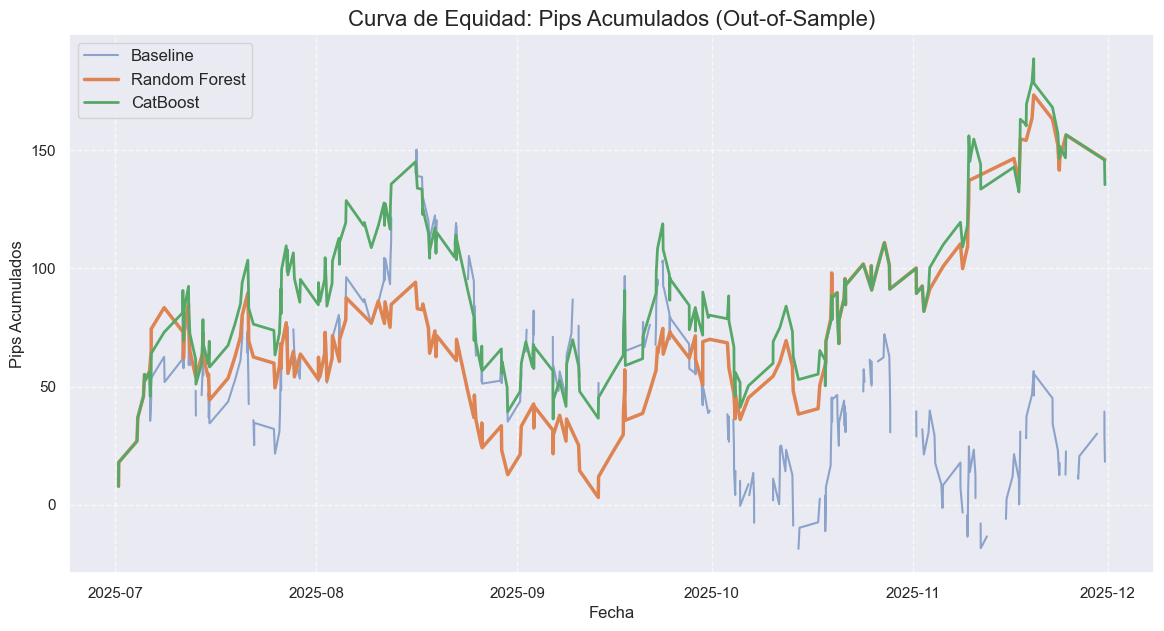

In [32]:
plt.figure(figsize=(14, 7))
if metrics_baseline:
    plt.plot(metrics_baseline['DataFrame']['signal_ts'], metrics_baseline['DataFrame']['cumulative_pips'], label='Baseline', alpha=0.6, linewidth=1.5)
if metrics_rf:
    plt.plot(metrics_rf['DataFrame']['signal_ts'], metrics_rf['DataFrame']['cumulative_pips'], label='Random Forest', linewidth=2.5)
if metrics_cb:
    plt.plot(metrics_cb['DataFrame']['signal_ts'], metrics_cb['DataFrame']['cumulative_pips'], label='CatBoost', linewidth=2)
plt.title('Curva de Equidad: Pips Acumulados (Out-of-Sample)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Pips Acumulados')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('final_equity_curve_comparison.png')
plt.show()


### Visualización de Drawdown

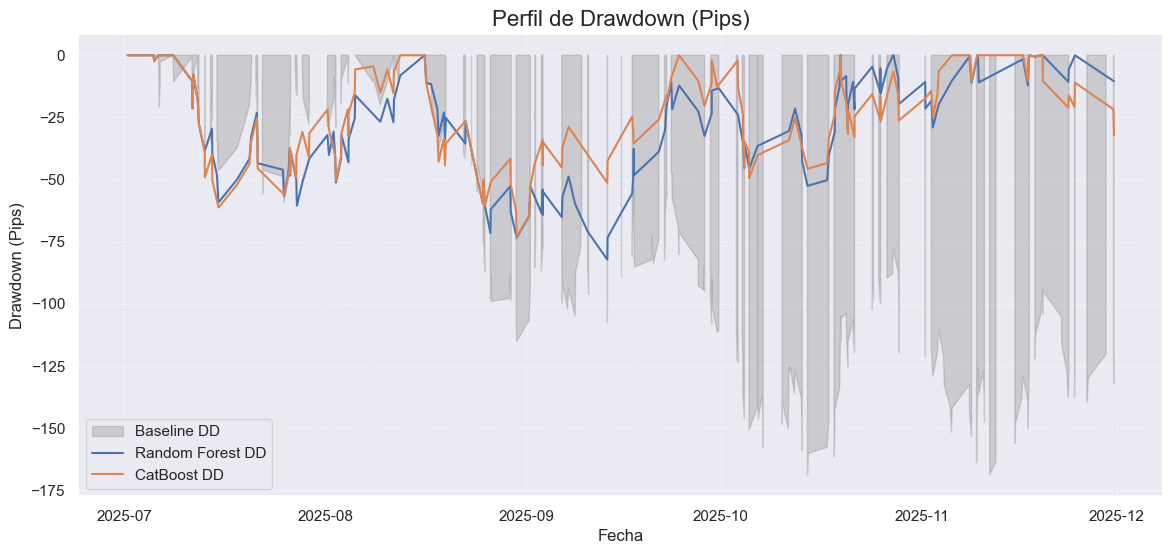

In [20]:
plt.figure(figsize=(14, 6))
if metrics_baseline:
    plt.fill_between(metrics_baseline['DataFrame']['signal_ts'], -metrics_baseline['DataFrame']['drawdown'], 0, color='gray', alpha=0.3, label='Baseline DD')
if metrics_rf:
    plt.plot(metrics_rf['DataFrame']['signal_ts'], -metrics_rf['DataFrame']['drawdown'], label='Random Forest DD', linewidth=1.5)
if metrics_cb:
    plt.plot(metrics_cb['DataFrame']['signal_ts'], -metrics_cb['DataFrame']['drawdown'], label='CatBoost DD', linewidth=1.5)
plt.title('Perfil de Drawdown (Pips)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Drawdown (Pips)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig('final_drawdown_comparison.png')
plt.show()
